# Anomalies Analysis 

Author: Nicolas Harvie </br>

In this notebook, we see to understand the relationship between CZ anomalies, exploring their characteristics as if they were stocks. We look at them visually, through exploratory data analysis and others. There will also be a section reserved to analysing the t-statistics of the alphas. 

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
# Predictors from Chen & Zimmerman (2020)
LS = pd.read_csv('../data/chen_predictors_2023.csv')
LS['date'] = pd.to_datetime(LS['date'])
LS = LS.set_index(LS['date'],drop=True)
LS = LS.drop(columns={'date'})

# Get the Same Index as the FF data by changing the time period 
LS.index = LS.reset_index()['date'].dt.to_period('M')
LS.index = LS.index.to_timestamp()

In [5]:
usrec = pd.read_csv("../data/USREC.csv", parse_dates=["DATE"]).set_index("DATE")['1990-01-01':'2022-12-31']
usrec["Rec_Start"] = usrec["USREC"].diff() == 1
usrec["Rec_End"] = usrec["USREC"].diff(-1) == 1
usrec[usrec["Rec_Start"] | usrec["Rec_End"]]
usrec = usrec[usrec["Rec_Start"] | usrec["Rec_End"]]
usrec["RecID"] = usrec["Rec_Start"].cumsum()
usrec = usrec.reset_index().set_index(["RecID", "Rec_End"])["DATE"].unstack("Rec_End")
usrec.columns = ["start_date", "end_date"]
usrec_dict = usrec.T.to_dict()
usrec_dict
usrec

,start_date,end_date
RecID,,
1,1990-08-01,1991-03-01
2,2001-04-01,2001-11-01
3,2008-01-01,2009-06-01
4,2020-03-01,2020-04-01


In [6]:
very_strong_anomalies = ['DivSeason', 'FirmAgeMom', 'MomSeason16YrPlus', 'NumEarnIncrease',
       'VolumeTrend', 'Tax', 'ShareIss1Y', 'RevenueSurprise',
       'MomOffSeason06YrPlus', 'ShortInterest', 'REV6', 'AnnouncementReturn',
       'NetPayoutYield', 'MS', 'EarningsStreak', 'DivOmit', 'ConvDebt', 'XFIN',
       'CPVolSpread', 'RIO_Volatility', 'ExchSwitch', 'SmileSlope',
       'ChangeInRecommendation']


In [7]:
LS_very_strong = LS[very_strong_anomalies]

In [8]:
def plot_heat_highcorr(df, threshold=0.5):
    plt.figure(figsize=(16, 8))
    sns.set(style="white")  # Use white background
    correlation_matrix = df.corr()
    above_threshold_corr = np.where(np.abs(correlation_matrix) > threshold, correlation_matrix, np.nan)
    heatmap = sns.heatmap(above_threshold_corr, annot=True, cmap="coolwarm", linewidths=.5)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha="right")
    plt.title("Correlation Matrix (Above 0.5)")
    
    above_threshold_vars = []
    for i, col in enumerate(correlation_matrix.columns):
        for j, corr_val in enumerate(correlation_matrix[col]):
            if np.abs(corr_val) > threshold and i != j:
                above_threshold_vars.append((col, correlation_matrix.columns[j]))
    
    if above_threshold_vars:
        print("Variable pairs with correlations above", threshold)
        for pair in above_threshold_vars:
            print(pair[0], "-", pair[1])
    else:
        print("No variable pairs with correlations above", threshold)
    
    plt.show()

In [9]:
def plot_heatcorr(df):
    plt.figure(figsize=(16, 8))
    sns.set(style="white")  # Use white background
    heatmap =sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=.5)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha="right")
    plt.title("Correlation Matrix")
    plt.show()

In [10]:
def plot_qheatcorr(df, q=0.25):
    plt.figure(figsize=(16, 8))
    sns.set(style="white")  # Use white background
    
    quantile_value = df.quantile(q)
    df_quantiles = df[df <= quantile_value]
    
    corr_matrix_quantiles = df_quantiles.corr()
    
    heatmap = sns.heatmap(corr_matrix_quantiles, annot=True, cmap="coolwarm", linewidths=.5)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha="right")
    plt.title(f"Correlation Matrix (Variables Below {q} Quantile)")
    plt.show()

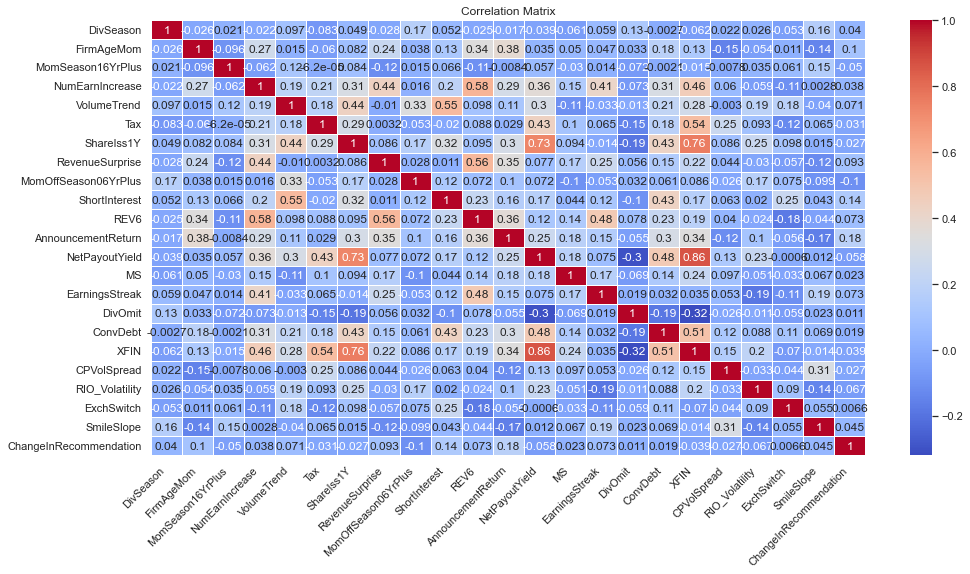

In [11]:
plot_heatcorr(LS_very_strong)

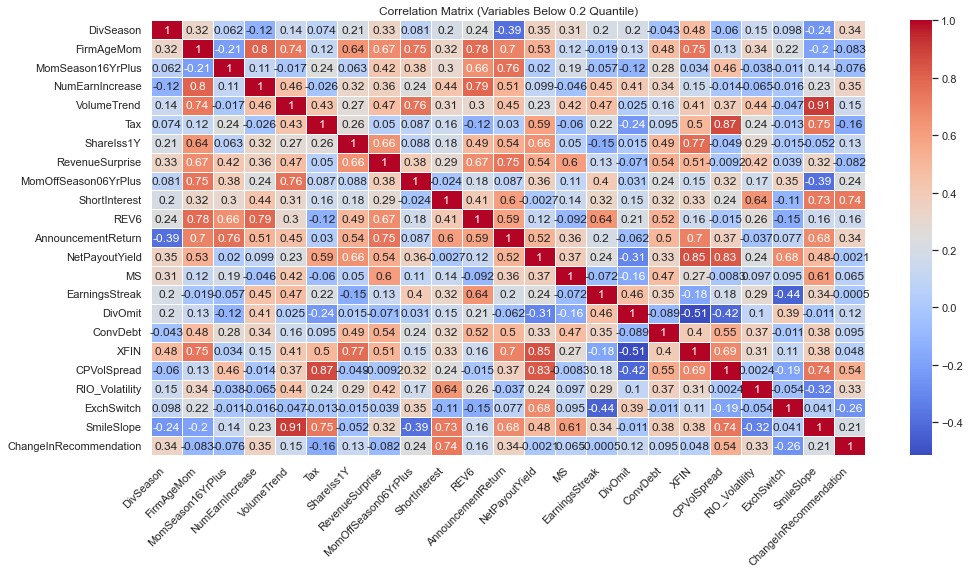

In [12]:
plot_qheatcorr(LS_very_strong, q=0.2)

In [14]:
def plot_subplots_with_correlations(data, column1, column2, quantile_values, rolling_window, usrec_dict):
    # Calculate rolling correlation
    rolling_corr = data[column1].rolling(window=rolling_window).corr(data[column2])

    # Create subplots with 2 rows and 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot rolling correlation in the first subplot
    axs[0, 0].plot(data.index, rolling_corr, label='Rolling Correlation', color='blue')
    axs[0, 0].axhline(y=0, color='gray', linestyle='--', label='Zero Correlation')
    axs[0, 0].axhline(y=rolling_corr.mean(), color='red', linestyle='--', label='Mean Correlation')
    axs[0, 0].set_xlabel('Index')
    axs[0, 0].set_ylabel('Rolling Correlation')
    axs[0, 0].set_title(f'Rolling Correlation between {column1} and {column2}')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    for x in usrec_dict:
        axs[0, 0].axvspan(usrec_dict[x]["start_date"], usrec_dict[x]["end_date"], color="black", alpha=0.15)

    for i, quantile_value in enumerate(quantile_values):
        row = (i + 1) // 2
        col = (i + 1) % 2

        # Calculate quantile values
        column1_quantile = data[column1].quantile(quantile_value)
        column2_quantile = data[column2].quantile(quantile_value)

        # Filter data below quantile
        filtered_data = data[(data[column1] < column1_quantile) & (data[column2] < column2_quantile)]
        correlation = filtered_data[column1].corr(filtered_data[column2])

        # Plot correlation below quantile in the remaining subplots
        sns.scatterplot(data=filtered_data, x=column1, y=column2, ax=axs[row, col])
        axs[row, col].set_title(f'Correlation below {quantile_value} Quantile\nCorrelation: {correlation:.2f}')
        axs[row, col].set_xlabel(column1)
        axs[row, col].set_ylabel(column2)
        axs[row, col].grid()

    plt.tight_layout()
    plt.show()


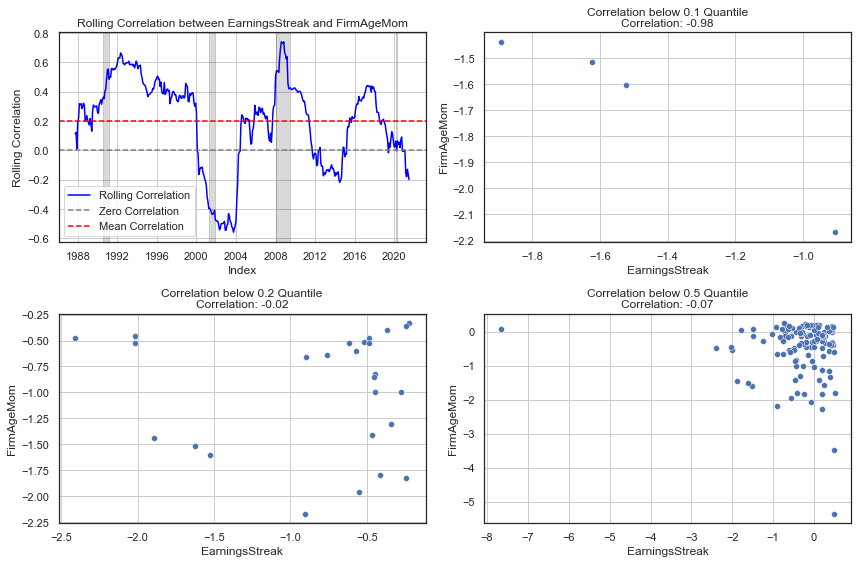

In [15]:
plot_subplots_with_correlations(LS / LS.std(), 'EarningsStreak', 'FirmAgeMom', [0.1, 0.2, 0.5], 36, usrec_dict)

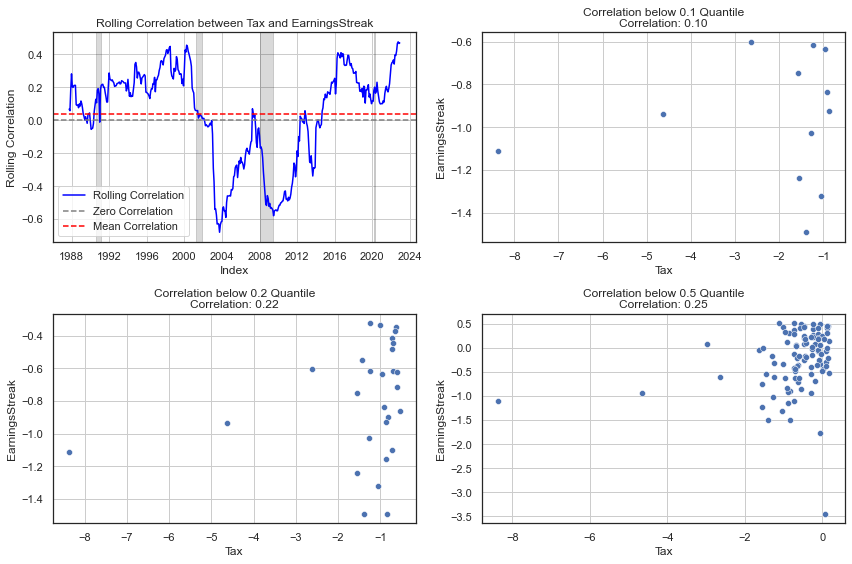

In [16]:
plot_subplots_with_correlations(LS / LS.std(), 'Tax', 'EarningsStreak', [0.1, 0.2, 0.5], 36, usrec_dict)

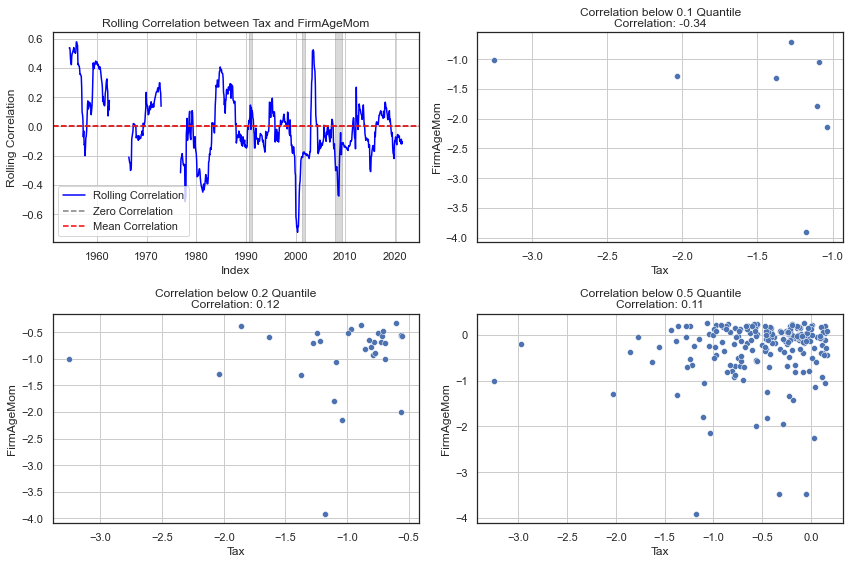

In [17]:
plot_subplots_with_correlations(LS / LS.std(), 'Tax', 'FirmAgeMom', [0.1, 0.2, 0.5], 36, usrec_dict)

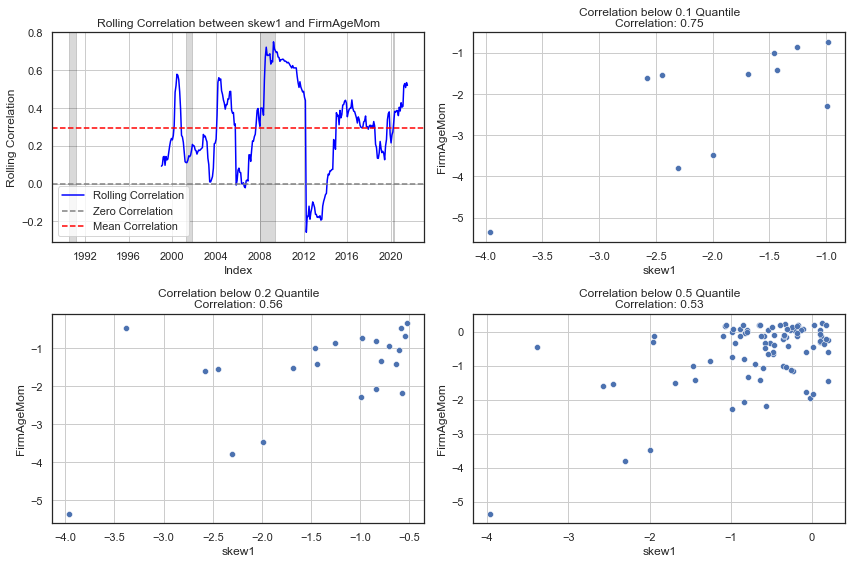

In [17]:
plot_subplots_with_correlations(LS / LS.std(), 'skew1', 'FirmAgeMom', [0.1, 0.2, 0.5], 36, usrec_dict)

In [18]:
LS_pct = LS / 100

In [19]:
def compare_rets(factor1, factor2):
    # Convert the 'date' column to datetime format

    compare = LS_pct[[factor1, factor2]].dropna().rolling(24).mean()

    compare.index = pd.to_datetime(compare.index)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(compare.index, compare[factor1], label=factor1)
    plt.plot(compare.index, compare[factor2], label=factor2)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Comparison of {factor1} and {factor2}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

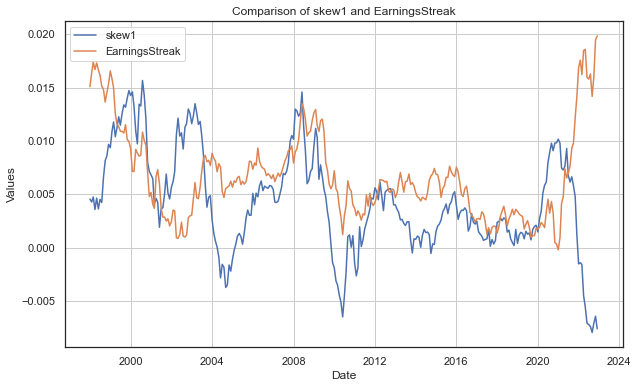

In [20]:
compare_rets('skew1', 'EarningsStreak')